## Code for plotting the Excel data exported from the Li-air Arbin cycler

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [3]:

def process_cell_basic(cell_data_path : str, cathode_mass : float, 
                       ):
    """Takes cell excel file as path and returns Pandas dataframe
    including all data as well as specific capacity

    Args:
        cell_data_path (str): full file path to cell data
        cathode_mass (float): float of cathode mass in mg

    Returns:
        df: Dataframe including all data as well as specific capacity
    """
    # extract the channel sheet from the file path    
    file_name = cell_data_path.split('\\')[-1]
    channel = file_name.split('_')[-2] +'_'+ file_name.split('_')[-1].split('.')[0]
    # read the data from the excel file
    spreadsheet = pd.read_excel(cell_data_path, sheet_name=channel+'_1')
    df = pd.DataFrame(spreadsheet)

    # multiplying by 1000 to convert from mg to g and multiplying by 1000 to convert from Ah/g to mAh/g
    df['Specific_Discharge_Capacity(mAh/g)'] = (df['Discharge_Capacity(Ah)']/cathode_mass)*10**6
    df['Specific_Charge_Capacity(mAh/g)'] = (df['Charge_Capacity(Ah)']/cathode_mass)*10**6
    return df





In [4]:
def get_first_cycle(df):
    """Takes dataframe of cell data and returns first cycle as dataframe
    Bases first cycle off of dV/dt
    Args:
        df (dataframe): dataframe of cell data

    Returns:
        df_first_cycle: dataframe of first cycle
    """
    # point where normalised dV/dt exceeds 0.1 for the first time
    first_cycle_index_end = np.where(df['dV/dt(V/s)']/df['dV/dt(V/s)'].max() > 0.2)[0][0]
    first_cycle_index_start = np.where(df['dV/dt(V/s)']/df['dV/dt(V/s)'].max() < -0.1)[0][0]
    #plot the first cycle
    df_first_cycle = df[first_cycle_index_start:first_cycle_index_end]
    return df_first_cycle


In [5]:
def plot_cell_data(cell_data_path : str,cathode_mass : float, 
                   title : str = None,
                   saveas : str = None, 
                   show_discharge : bool = False,
                   show_charge : bool = False,
                   skip_rest : bool = True, 
                   size : tuple= None):
    df = process_cell_basic(cell_data_path, cathode_mass)
    if skip_rest:
            df = df[df['Test_Time(s)'] > ((8*3600)-5)]
            # print(df.head())
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    if show_discharge:
        ax2.plot(df['Test_Time(s)']/3600, df['Specific_Discharge_Capacity(mAh/g)'],alpha=0.75, color='red',
                 label='Discharge Capacity (mAh/g)')
    if show_charge:
        ax2.plot(df['Test_Time(s)']/3600, df['Specific_Charge_Capacity(mAh/g)'],alpha=0.75, color='black',
                 label='Charge Capacity (mAh/g)')
    ax1.plot(df['Test_Time(s)']/3600, df['Voltage(V)'],label='Voltage (V)')
    # ax1.set_xlabel('Specific Capacity (mAh/g)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_xlabel('Time (hours)')
    ax2.set_ylabel('Specific Capacity (mAh/g)')
    # ax1.legend()
    if show_discharge and show_charge:
        ax2.legend()
    fig.show()
    if title == None:
        title = cell_data_path.split('\\')[-1]
    ax1.set_title(title)
    if size != None:
        fig.set_size_inches(size)
    if type(saveas) == str:
        fig.savefig(saveas, dpi=300)


In [6]:
class CellData:
    def __init__(self, path, label, mass):
        self.path = path
        self.label = label
        self.mass = mass

In [7]:
def return_deep_discharge(path, cathode_mass):
    df = process_cell_basic(path, cathode_mass)
    # df = process_cell_basic(path_100mA_unpat, 1.2)
    df = df[df['Cycle_Index'] == 1]
    indices = df.index[df['Step_Index'] == 2].tolist()
    indices.insert(0,indices[0]-1)
    return df.iloc[indices]


In [8]:
def plot_multiple_firstcycle(
        cell_data : list[CellData],
        colors : list[str] or None = None,
        styles : list[str] or None = None,
        legend : tuple or list or bool = True, #(list(lines), list(labels)))
        **kwargs
):
    fig, ax = plt.subplots()
    i = 0
    for cell in cell_data:
        df = return_deep_discharge(cell.path, cell.mass)
        if colors is None:
            ax.plot(df['Specific_Discharge_Capacity(mAh/g)'], df['Voltage(V)'], label=cell.label)
        else:
            ax.plot(df['Specific_Discharge_Capacity(mAh/g)'], df['Voltage(V)'], label=cell.label,
                color = colors[i], linestyle = styles[i])
        i+=1
    plt.axhline(y=2.96, color='r', linestyle='dotted')
    # write text just above this line stating the voltage
    plt.text(100, 3, 'E$^0$ = 2.96 V', color='r')
    ax.set_xlabel('Specific Capacity (mAh/g)')
    ax.set_ylabel('Voltage (V)')
    if type(legend) == tuple or type(legend) == list:
        ax.legend(legend[0], legend[1])
    elif legend:
        ax.legend()
    
    for key, value in kwargs.items():
        if key == 'title':
            ax.set_title(value)
        if key == 'size':
            fig.set_size_inches(value)
        if key == 'saveas':
            fig.savefig(value)
    
    plt.show()

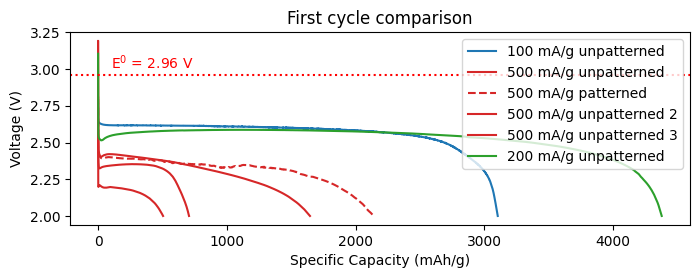

In [76]:
path_500mAg_unpat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_500mAg_20230717\Channel_18\lb958_MWCNTs_126_500mAg_20230717_Channel_18.xlsx"
mass_500mAg_unpat = 1.26

path_500mAg_pat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTspat_105_500mAg_20230727\Channel_5\lb958_MWCNTspat_105_500mAg_20230727_Channel_5.xlsx"
mass_500mAg_pat = 1.05

path_100mAg_unpat = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_100mAg_20230717\Channel_19\lb958_MWCNTs_125_100mAg_20230717_Channel_19.xlsx"
mass_100mAg_unpat = 1.25

path_500mAg_unpat_2 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717\Channel_7\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717_Channel_7.xlsx"
mass_500mAg_unpat_2 = 1.24

path_500mAg_unpat_3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_144_500mAg_20230731\Channel_8\lb958_MWCNTs_144_500mAg_20230731_Channel_8.xlsx"
mass_500mAg_unpat_3 = 1.44

path_200mAg_unpat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_200mAg_20230727\Channel_6\lb958_MWCNTs_125_200mAg_20230727_Channel_6.xlsx"
mass_200mAg_unpat = 1.25


cell_500mAg_unpat = CellData(path_500mAg_unpat, '500 mA/g unpatterned', mass_500mAg_unpat)
cell_500mAg_pat = CellData(path_500mAg_pat, '500 mA/g patterned', mass_500mAg_pat)
cell_100mAg_unpat = CellData(path_100mAg_unpat, '100 mA/g unpatterned', mass_100mAg_unpat)
cell_500mAg_unpat_2 = CellData(path_500mAg_unpat_2, '500 mA/g unpatterned 2', mass_500mAg_unpat_2)
cell_500mAg_unpat_3 = CellData(path_500mAg_unpat_3, '500 mA/g unpatterned 3', mass_500mAg_unpat_3)
cell_200mAg_unpat = CellData(path_200mAg_unpat, '200 mA/g unpatterned', mass_200mAg_unpat)

styles = ['-','-','--','-','-', '-']
colors = ['tab:blue','tab:red','tab:red','tab:red', 'tab:red', 'tab:green']



plot_multiple_firstcycle([cell_100mAg_unpat,cell_500mAg_unpat, cell_500mAg_pat, cell_500mAg_unpat_2, cell_500mAg_unpat_3, cell_200mAg_unpat],
                          styles=styles, colors = colors,
                         title= 'First cycle comparison',size=(8,2.5),
                         )

C:\Users\lb958\AppData\Local\Temp\ipykernel_10484\991266339.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


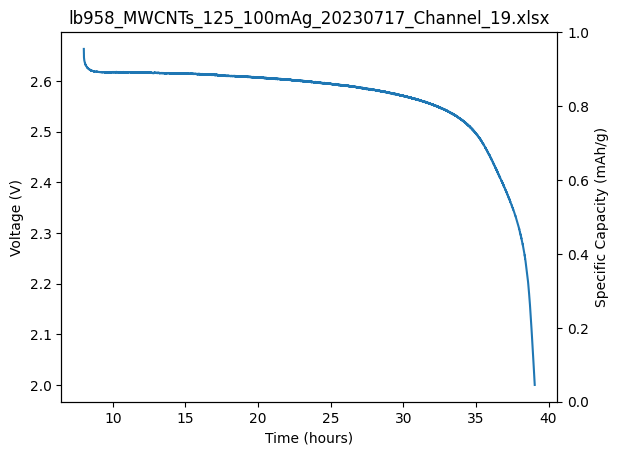

In [45]:
plot_cell_data(path_100mAg_unpat,mass_100mAg_unpat)

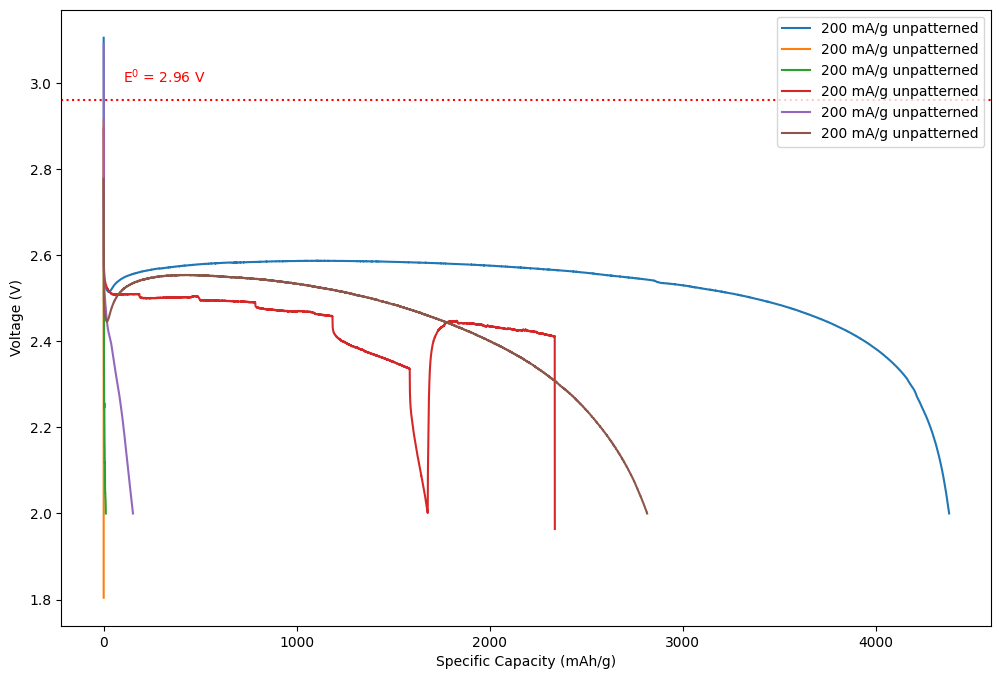

In [69]:
path_200mAg_unpat2 = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_136_200mAg_20230727\Channel_8\lb958_MWCNTs_136_200mAg_20230727_Channel_8.xlsx"
mass_200mAg_unpat2 = 1.36
cell_200mAg_unpat2 = CellData(path_200mAg_unpat2, '200 mA/g unpatterned', mass_200mAg_unpat2)

path_200mAg_unpat3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_132_200mAg_20230721\Channel_6\lb958_MWCNTs_132_200mAg_20230721_Channel_6.xlsx"
mass_200mAg_unpat3 = 1.32
cell_200mAg_unpat3 = CellData(path_200mAg_unpat3, '200 mA/g unpatterned', mass_200mAg_unpat3)

path_200mAg_unpat4 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_122_200mAg_20230731\Channel_6\lb958_MWCNTs_122_200mAg_20230731_Channel_6.xlsx"
mass_200mAg_unpat4 = 1.22
cell_200mAg_unpat4 = CellData(path_200mAg_unpat4, '200 mA/g unpatterned', mass_200mAg_unpat4)

path_200mAg_unpat5 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_127_200mAg_20230721\Channel_5\lb958_MWCNTs_127_200mAg_20230721_Channel_5.xlsx"
mass_200mAg_unpat5 = 1.27
cell_200mAg_unpat5 = CellData(path_200mAg_unpat5, '200 mA/g unpatterned', mass_200mAg_unpat5)

path_200mAg_unpat6 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721\Channel_23\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721_Channel_23.xlsx"
mass_200mAg_unpat6 = 1.21
cell_200mAg_unpat6 = CellData(path_200mAg_unpat6, '200 mA/g unpatterned', mass_200mAg_unpat6)

plot_multiple_firstcycle([cell_200mAg_unpat, cell_200mAg_unpat2, cell_200mAg_unpat3, cell_200mAg_unpat4, cell_200mAg_unpat5,
                          cell_200mAg_unpat6],
                         size=(12,8))

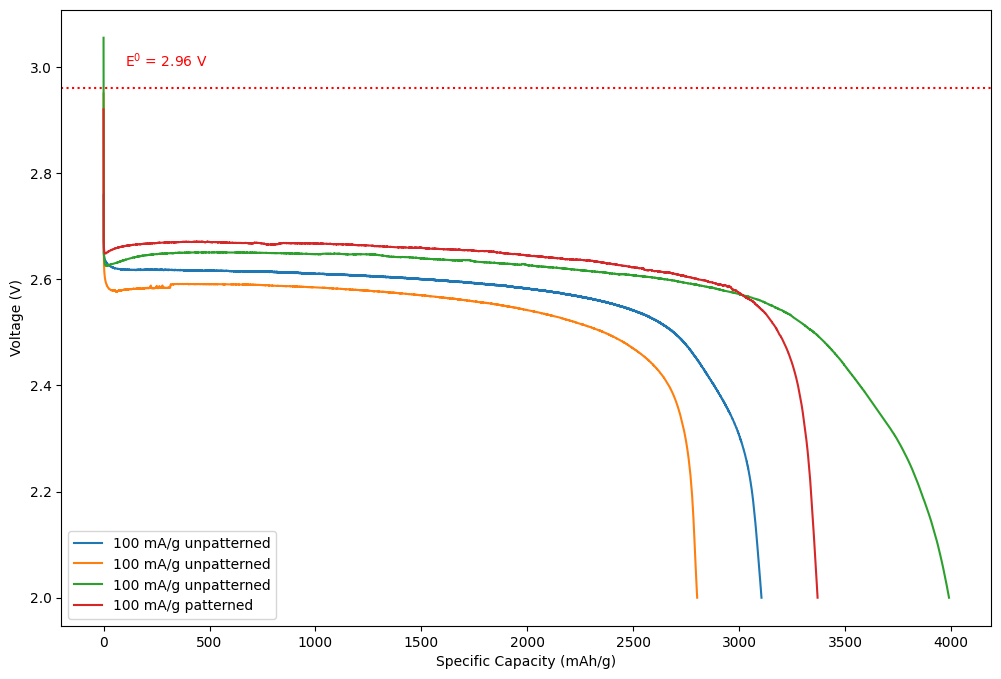

In [68]:
path_100mAg_unpat2 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_100mAg_230717\Channel_20\lb958_MWCNTs_126_100mAg_230717_Channel_20.xlsx"
mass_100mAg_unpat2 = 1.26
cell_100mAg_unpat2 = CellData(path_100mAg_unpat2, "100 mA/g unpatterned", mass_100mAg_unpat2)

path_100mAg_pat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb968_MWCNTspat_81mov_100mAg_20230801\Channel_5\lb968_MWCNTspat_81mov_100mAg_20230801_Channel_5.xlsx"
mass_100mAg_pat = 0.81
cell_100mAg_pat = CellData(path_100mAg_pat, "100 mA/g patterned", mass_100mAg_pat)

path_100mAg_unpat3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721\Channel_7\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721_Channel_7.xlsx"
mass_100mAg_unpat3 = 1.19
cell_100mAg_unpat3 = CellData(path_100mAg_unpat3, "100 mA/g unpatterned", mass_100mAg_unpat3)

plot_multiple_firstcycle([cell_100mAg_unpat, cell_100mAg_unpat2, cell_100mAg_unpat3, cell_100mAg_pat], size = (12,8))

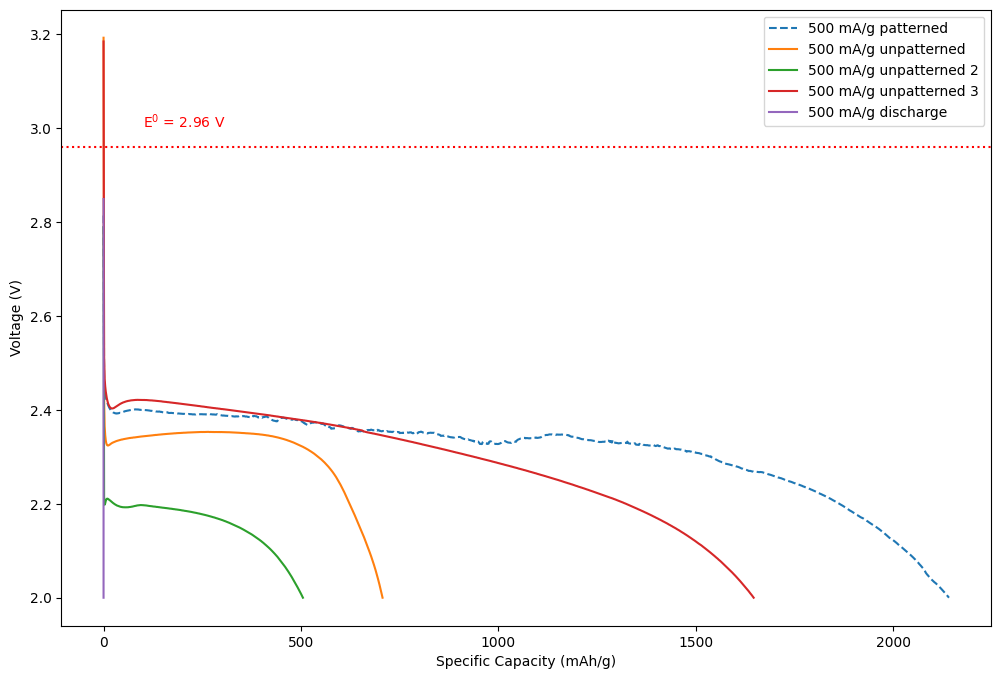

In [17]:
path_500mAg_unpat4 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_128_500mAg_20230717\Channel_8\lb958_MWCNTs_128_500mAg_20230717_Channel_8.xlsx"
mass_500mAg_unpat4 = 1.28
cell_500mAg_unpat4 = CellData(path_500mAg_unpat4, "500 mA/g discharge" ,mass_500mAg_unpat4)

styles = ['dashed','-','-','-','-',]
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
plot_multiple_firstcycle([cell_500mAg_pat,cell_500mAg_unpat, cell_500mAg_unpat_2, cell_500mAg_unpat_3, cell_500mAg_unpat4],
                         styles=styles, colors=colors,size=(12,8))

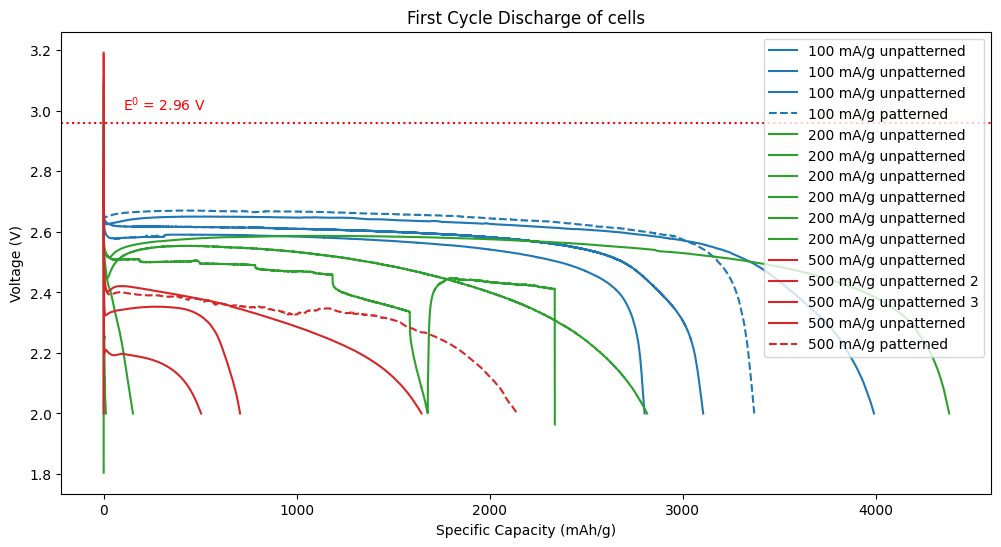

In [71]:
path_500mAg_unpat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_500mAg_20230717\Channel_18\lb958_MWCNTs_126_500mAg_20230717_Channel_18.xlsx"
mass_500mAg_unpat = 1.26

path_500mAg_pat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTspat_105_500mAg_20230727\Channel_5\lb958_MWCNTspat_105_500mAg_20230727_Channel_5.xlsx"
mass_500mAg_pat = 1.05

path_100mAg_unpat = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_100mAg_20230717\Channel_19\lb958_MWCNTs_125_100mAg_20230717_Channel_19.xlsx"
mass_100mAg_unpat = 1.25

path_500mAg_unpat_2 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717\Channel_7\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717_Channel_7.xlsx"
mass_500mAg_unpat_2 = 1.24

path_500mAg_unpat_3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_144_500mAg_20230731\Channel_8\lb958_MWCNTs_144_500mAg_20230731_Channel_8.xlsx"
mass_500mAg_unpat_3 = 1.44

path_200mAg_unpat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_200mAg_20230727\Channel_6\lb958_MWCNTs_125_200mAg_20230727_Channel_6.xlsx"
mass_200mAg_unpat = 1.25


cell_500mAg_unpat = CellData(path_500mAg_unpat, '500 mA/g unpatterned', mass_500mAg_unpat)
cell_500mAg_pat = CellData(path_500mAg_pat, '500 mA/g patterned', mass_500mAg_pat)
cell_100mAg_unpat = CellData(path_100mAg_unpat, '100 mA/g unpatterned', mass_100mAg_unpat)
cell_500mAg_unpat_2 = CellData(path_500mAg_unpat_2, '500 mA/g unpatterned 2', mass_500mAg_unpat_2)
cell_500mAg_unpat_3 = CellData(path_500mAg_unpat_3, '500 mA/g unpatterned 3', mass_500mAg_unpat_3)
cell_200mAg_unpat = CellData(path_200mAg_unpat, '200 mA/g unpatterned', mass_200mAg_unpat)

path_200mAg_unpat2 = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_136_200mAg_20230727\Channel_8\lb958_MWCNTs_136_200mAg_20230727_Channel_8.xlsx"
mass_200mAg_unpat2 = 1.36
cell_200mAg_unpat2 = CellData(path_200mAg_unpat2, '200 mA/g unpatterned', mass_200mAg_unpat2)

path_200mAg_unpat3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_132_200mAg_20230721\Channel_6\lb958_MWCNTs_132_200mAg_20230721_Channel_6.xlsx"
mass_200mAg_unpat3 = 1.32
cell_200mAg_unpat3 = CellData(path_200mAg_unpat3, '200 mA/g unpatterned', mass_200mAg_unpat3)

path_200mAg_unpat4 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_122_200mAg_20230731\Channel_6\lb958_MWCNTs_122_200mAg_20230731_Channel_6.xlsx"
mass_200mAg_unpat4 = 1.22
cell_200mAg_unpat4 = CellData(path_200mAg_unpat4, '200 mA/g unpatterned', mass_200mAg_unpat4)

path_200mAg_unpat5 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_127_200mAg_20230721\Channel_5\lb958_MWCNTs_127_200mAg_20230721_Channel_5.xlsx"
mass_200mAg_unpat5 = 1.27
cell_200mAg_unpat5 = CellData(path_200mAg_unpat5, '200 mA/g unpatterned', mass_200mAg_unpat5)

path_200mAg_unpat6 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721\Channel_23\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721_Channel_23.xlsx"
mass_200mAg_unpat6 = 1.21
cell_200mAg_unpat6 = CellData(path_200mAg_unpat6, '200 mA/g unpatterned', mass_200mAg_unpat6)

path_100mAg_unpat2 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_100mAg_230717\Channel_20\lb958_MWCNTs_126_100mAg_230717_Channel_20.xlsx"
mass_100mAg_unpat2 = 1.26
cell_100mAg_unpat2 = CellData(path_100mAg_unpat2, "100 mA/g unpatterned", mass_100mAg_unpat2)

path_100mAg_unpat3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721\Channel_7\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721_Channel_7.xlsx"
mass_100mAg_unpat3 = 1.19
cell_100mAg_unpat3 = CellData(path_100mAg_unpat3, "100 mA/g unpatterned", mass_100mAg_unpat3)

path_500mAg_unpat4 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_128_500mAg_20230717\Channel_8\lb958_MWCNTs_128_500mAg_20230717_Channel_8.xlsx"
mass_500mAg_unpat4 = 1.28
cell_500mAg_unpat4 = CellData(path_500mAg_unpat4, "500 mA/g unpatterned" ,mass_500mAg_unpat4)

path_100mAg_pat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb968_MWCNTspat_81mov_100mAg_20230801\Channel_5\lb968_MWCNTspat_81mov_100mAg_20230801_Channel_5.xlsx"
mass_100mAg_pat = 0.81
cell_100mAg_pat = CellData(path_100mAg_pat, "100 mA/g patterned", mass_100mAg_pat)



# STILL TO INCLUDE; 200 MAG CYCLING, 500 MAG CYCLING, 100 MAG PATTERNED DISCHARGE

cell_list = [cell_100mAg_unpat,cell_100mAg_unpat2,cell_100mAg_unpat3,
             cell_100mAg_pat,
             cell_200mAg_unpat,cell_200mAg_unpat2,cell_200mAg_unpat3,cell_200mAg_unpat4,cell_200mAg_unpat5,cell_200mAg_unpat6,
             cell_500mAg_unpat, cell_500mAg_unpat_2, cell_500mAg_unpat_3, cell_500mAg_unpat4, 
             cell_500mAg_pat]

colors = ['tab:blue','tab:blue','tab:blue',
          'tab:blue',
          'tab:green','tab:green','tab:green','tab:green','tab:green','tab:green',
          'tab:red','tab:red','tab:red','tab:red',
          'tab:red']

styles = ['-','-','-',
          '--',
          '-','-','-','-','-','-',
          '-','-','-','-',
          '--']

plot_multiple_firstcycle(cell_data=cell_list,colors = colors, styles = styles, 
                         title = 'First Cycle Discharge of cells',
                         size=(12,6))



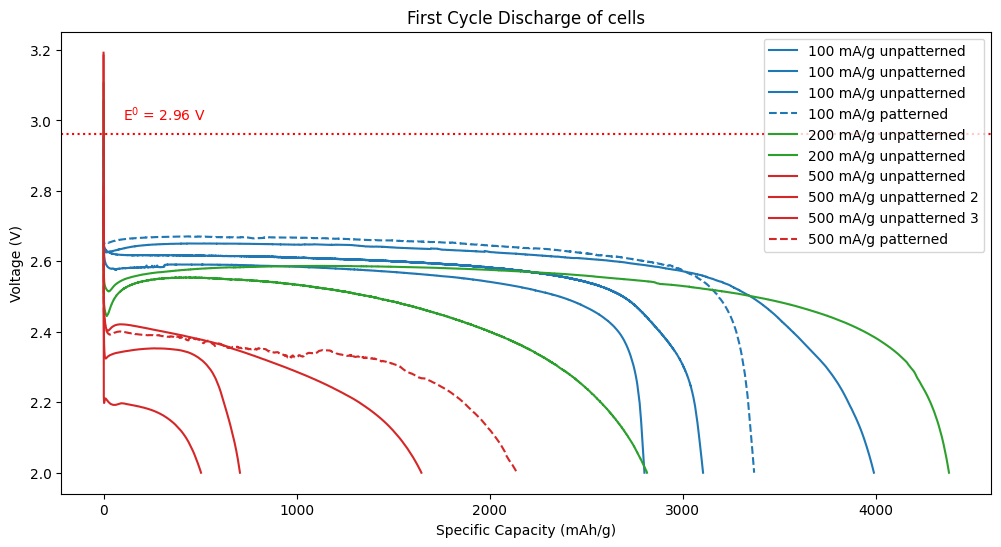

In [12]:
path_500mAg_unpat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_500mAg_20230717\Channel_18\lb958_MWCNTs_126_500mAg_20230717_Channel_18.xlsx"
mass_500mAg_unpat = 1.26

path_500mAg_pat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTspat_105_500mAg_20230727\Channel_5\lb958_MWCNTspat_105_500mAg_20230727_Channel_5.xlsx"
mass_500mAg_pat = 1.05

path_100mAg_unpat = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_100mAg_20230717\Channel_19\lb958_MWCNTs_125_100mAg_20230717_Channel_19.xlsx"
mass_100mAg_unpat = 1.25

path_500mAg_unpat_2 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717\Channel_7\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717_Channel_7.xlsx"
mass_500mAg_unpat_2 = 1.24

path_500mAg_unpat_3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_144_500mAg_20230731\Channel_8\lb958_MWCNTs_144_500mAg_20230731_Channel_8.xlsx"
mass_500mAg_unpat_3 = 1.44

path_200mAg_unpat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_200mAg_20230727\Channel_6\lb958_MWCNTs_125_200mAg_20230727_Channel_6.xlsx"
mass_200mAg_unpat = 1.25


cell_500mAg_unpat = CellData(path_500mAg_unpat, '500 mA/g unpatterned', mass_500mAg_unpat)
cell_500mAg_pat = CellData(path_500mAg_pat, '500 mA/g patterned', mass_500mAg_pat)
cell_100mAg_unpat = CellData(path_100mAg_unpat, '100 mA/g unpatterned', mass_100mAg_unpat)
cell_500mAg_unpat_2 = CellData(path_500mAg_unpat_2, '500 mA/g unpatterned 2', mass_500mAg_unpat_2)
cell_500mAg_unpat_3 = CellData(path_500mAg_unpat_3, '500 mA/g unpatterned 3', mass_500mAg_unpat_3)
cell_200mAg_unpat = CellData(path_200mAg_unpat, '200 mA/g unpatterned', mass_200mAg_unpat)

path_200mAg_unpat2 = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_136_200mAg_20230727\Channel_8\lb958_MWCNTs_136_200mAg_20230727_Channel_8.xlsx"
mass_200mAg_unpat2 = 1.36
cell_200mAg_unpat2 = CellData(path_200mAg_unpat2, '200 mA/g unpatterned', mass_200mAg_unpat2)

path_200mAg_unpat3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_132_200mAg_20230721\Channel_6\lb958_MWCNTs_132_200mAg_20230721_Channel_6.xlsx"
mass_200mAg_unpat3 = 1.32
cell_200mAg_unpat3 = CellData(path_200mAg_unpat3, '200 mA/g unpatterned', mass_200mAg_unpat3)

path_200mAg_unpat4 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_122_200mAg_20230731\Channel_6\lb958_MWCNTs_122_200mAg_20230731_Channel_6.xlsx"
mass_200mAg_unpat4 = 1.22
cell_200mAg_unpat4 = CellData(path_200mAg_unpat4, '200 mA/g unpatterned', mass_200mAg_unpat4)

path_200mAg_unpat5 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_127_200mAg_20230721\Channel_5\lb958_MWCNTs_127_200mAg_20230721_Channel_5.xlsx"
mass_200mAg_unpat5 = 1.27
cell_200mAg_unpat5 = CellData(path_200mAg_unpat5, '200 mA/g unpatterned', mass_200mAg_unpat5)

path_200mAg_unpat6 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721\Channel_23\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721_Channel_23.xlsx"
mass_200mAg_unpat6 = 1.21
cell_200mAg_unpat6 = CellData(path_200mAg_unpat6, '200 mA/g unpatterned', mass_200mAg_unpat6)

path_100mAg_unpat2 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_100mAg_230717\Channel_20\lb958_MWCNTs_126_100mAg_230717_Channel_20.xlsx"
mass_100mAg_unpat2 = 1.26
cell_100mAg_unpat2 = CellData(path_100mAg_unpat2, "100 mA/g unpatterned", mass_100mAg_unpat2)

path_100mAg_unpat3 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721\Channel_7\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721_Channel_7.xlsx"
mass_100mAg_unpat3 = 1.19
cell_100mAg_unpat3 = CellData(path_100mAg_unpat3, "100 mA/g unpatterned", mass_100mAg_unpat3)

path_500mAg_unpat4 = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_128_500mAg_20230717\Channel_8\lb958_MWCNTs_128_500mAg_20230717_Channel_8.xlsx"
mass_500mAg_unpat4 = 1.28
cell_500mAg_unpat4 = CellData(path_500mAg_unpat4, "500 mA/g unpatterned" ,mass_500mAg_unpat4)

path_100mAg_pat = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb968_MWCNTspat_81mov_100mAg_20230801\Channel_5\lb968_MWCNTspat_81mov_100mAg_20230801_Channel_5.xlsx"
mass_100mAg_pat = 0.81
cell_100mAg_pat = CellData(path_100mAg_pat, "100 mA/g patterned", mass_100mAg_pat)



# STILL TO INCLUDE; 200 MAG CYCLING, 500 MAG CYCLING, 100 MAG PATTERNED DISCHARGE

cell_list = [cell_100mAg_unpat,cell_100mAg_unpat2,cell_100mAg_unpat3,
             cell_100mAg_pat,
             cell_200mAg_unpat,cell_200mAg_unpat6,
             cell_500mAg_unpat, cell_500mAg_unpat_2, cell_500mAg_unpat_3, 
             cell_500mAg_pat]

colors = ['tab:blue','tab:blue','tab:blue',
          'tab:blue',
          'tab:green','tab:green',
          'tab:red','tab:red','tab:red',
          'tab:red']

styles = ['-','-','-',
          '--',
          '-','-',
          '-','-','-',
          '--']

plot_multiple_firstcycle(cell_data=cell_list,colors = colors, styles = styles, 
                         title = 'First Cycle Discharge of cells',
                         size=(12,6))



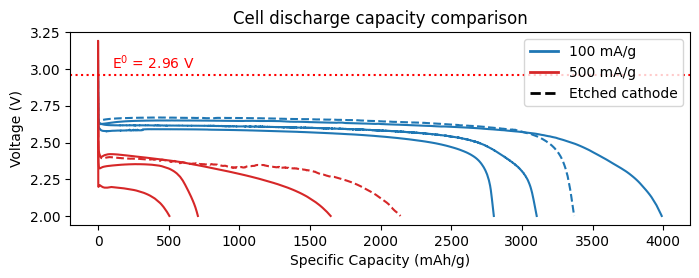

In [86]:

cell_list = [cell_100mAg_unpat,cell_100mAg_unpat2,cell_100mAg_unpat3,
             cell_100mAg_pat,
             cell_500mAg_unpat, cell_500mAg_unpat_2, cell_500mAg_unpat_3, #cell_500mAg_unpat4, 
             cell_500mAg_pat]

colors = ['tab:blue','tab:blue','tab:blue',
          'tab:blue',
          'tab:red','tab:red','tab:red',
          'tab:red']

styles = ['-','-','-',
          '--',
          '-','-','-',
          '--']

custom_lines = [Line2D([0], [0], color='tab:blue', lw=2),
                Line2D([0], [0], color='tab:red', lw=2), 
                Line2D([0], [0], color='k',linestyle='--', lw=2)]
custom_labels = ['100 mA/g', '500 mA/g', 'Etched cathode']

plot_multiple_firstcycle(cell_list,
                          styles=styles, colors = colors,
                          title = "Cell discharge capacity comparison",
                         size=(8,2.5),
                         legend=(custom_lines,custom_labels))

                  Date_Time  Test_Time(s)  Step_Time(s)  Step_Index  \
479 2023-07-18 02:15:39.861  28800.000000    28799.9996           1   
480 2023-07-18 02:15:49.948  28810.086016       10.0002           2   
481 2023-07-18 02:15:59.948  28820.086516       20.0007           2   
482 2023-07-18 02:16:09.949  28830.086616       30.0008           2   
483 2023-07-18 02:16:19.948  28840.085916       40.0001           2   

     Cycle_Index  Voltage(V)  Current(A)  Charge_Capacity(Ah)  \
479            1    2.789030     0.00000                  0.0   
480            1    2.214012    -0.00062                  0.0   
481            1    2.197876    -0.00062                  0.0   
482            1    2.200932    -0.00062                  0.0   
483            1    2.205908    -0.00062                  0.0   

     Discharge_Capacity(Ah)  Charge_Energy(Wh)  Discharge_Energy(Wh)  \
479                0.000000                0.0              0.000000   
480                0.000002           

C:\Users\lb958\AppData\Local\Temp\ipykernel_10484\2537910645.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


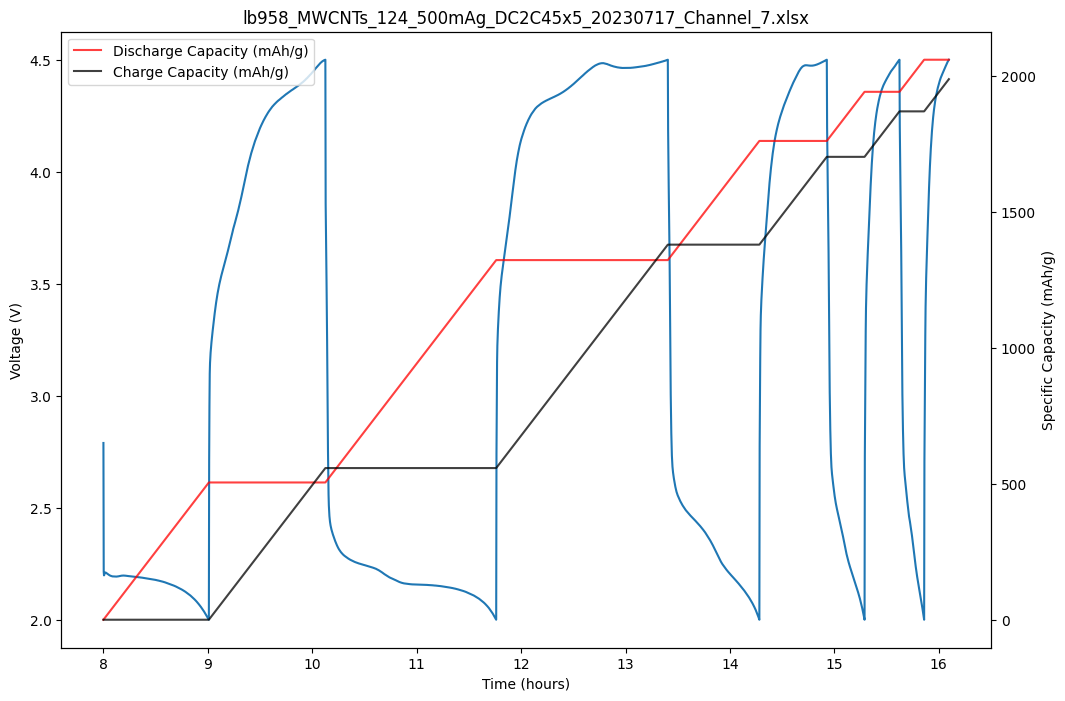

In [61]:
plot_cell_data(r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717\Channel_7\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717_Channel_7.xlsx",
               1.24, show_charge=True, show_discharge=True, size=(12,8))

                  Date_Time  Test_Time(s)  Step_Time(s)  Step_Index  \
479 2023-07-22 02:27:04.091  28799.999900    28799.9995           1   
480 2023-07-22 02:27:14.181  28810.090012       10.0004           2   
481 2023-07-22 02:27:24.181  28820.090612       20.0010           2   
482 2023-07-22 02:27:34.181  28830.090612       30.0010           2   
483 2023-07-22 02:27:44.182  28840.091212       40.0016           2   

     Cycle_Index  Voltage(V)  Current(A)  Charge_Capacity(Ah)  \
479            1    2.777916    0.000000                  0.0   
480            1    2.516518   -0.000242                  0.0   
481            1    2.495802   -0.000242                  0.0   
482            1    2.486925   -0.000242                  0.0   
483            1    2.480793   -0.000242                  0.0   

     Discharge_Capacity(Ah)  Charge_Energy(Wh)  Discharge_Energy(Wh)  \
479            0.000000e+00                0.0              0.000000   
480            6.731707e-07           

C:\Users\lb958\AppData\Local\Temp\ipykernel_10484\2537910645.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


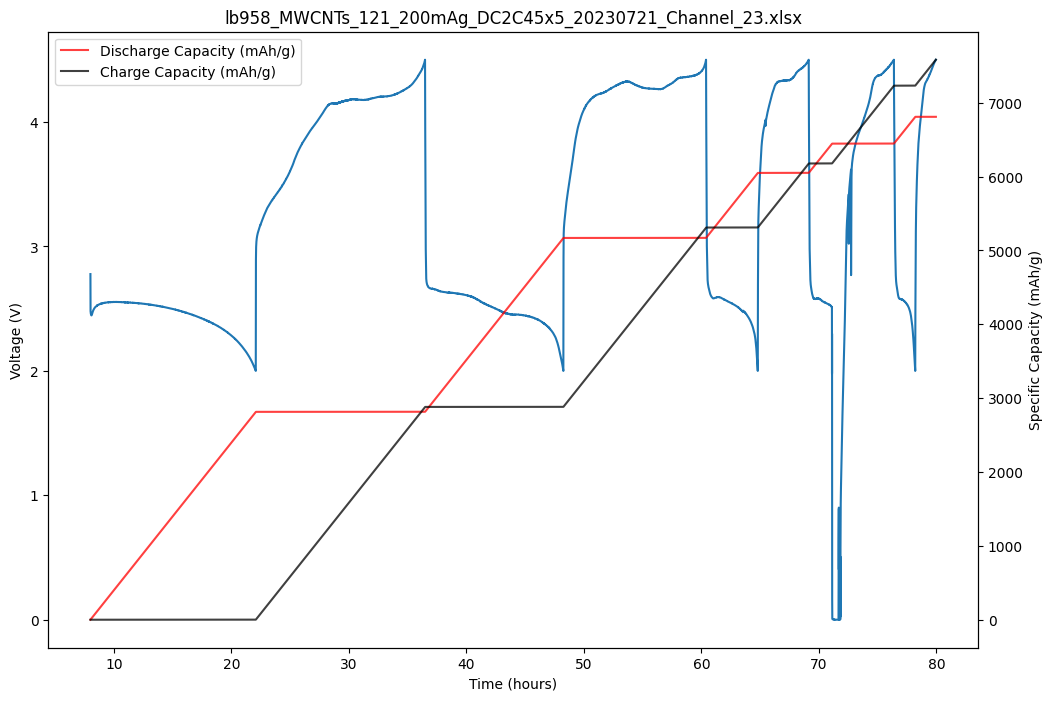

In [64]:
plot_cell_data(r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721\Channel_23\lb958_MWCNTs_121_200mAg_DC2C45x5_20230721_Channel_23.xlsx",
               1.21, show_charge=True, show_discharge=True, size=(12,8))

C:\Users\lb958\AppData\Local\Temp\ipykernel_10484\3291590197.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


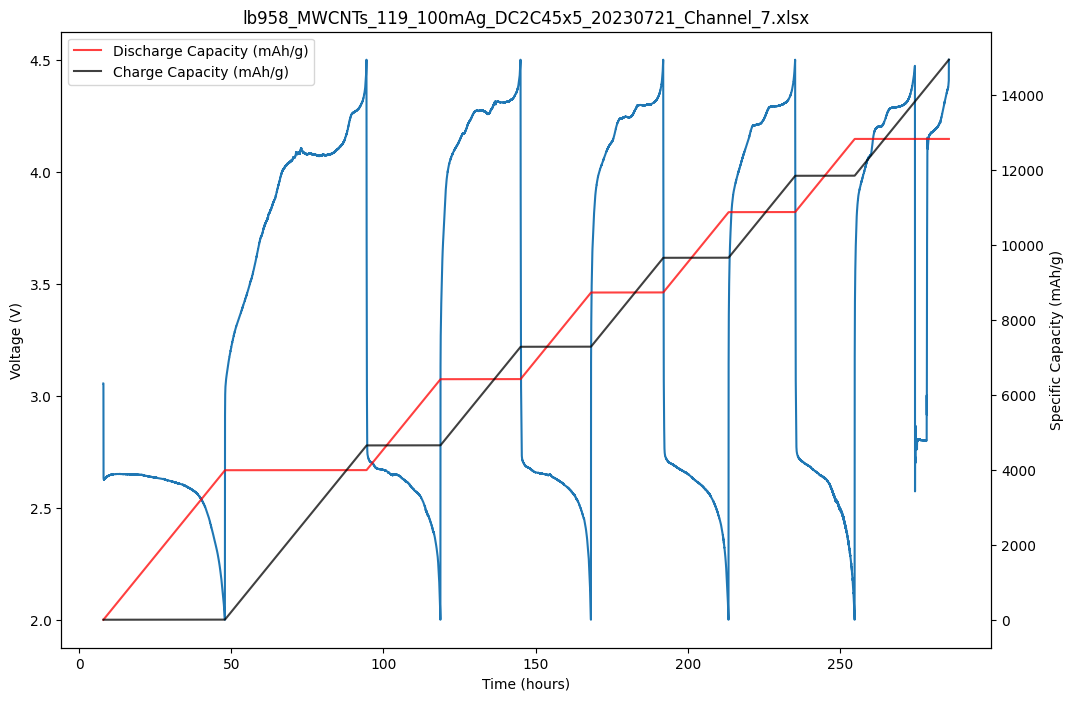

In [66]:
plot_cell_data(r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721\Channel_7\lb958_MWCNTs_119_100mAg_DC2C45x5_20230721_Channel_7.xlsx",
               1.19, show_charge=True, show_discharge=True, size=(12,8))

In [52]:
file_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_CNTS_1625_23523\Channel_19\lb958_CNTS_1497_23523lb958_CNTS_1625_23523_Channel_19.xlsx"
file_name = file_path.split('\\')[-1]
channel = file_name.split('_')[-2] +'_'+ file_name.split('_')[-1].split('.')[0]
print(channel)

Channel_19


In [5]:
spreadsheet = pd.read_excel(file_path, sheet_name=channel+'_1')
df = pd.DataFrame(spreadsheet)
df.head()

,Date_Time,Test_Time(s),Step_Time(s),Step_Index,Cycle_Index,Voltage(V),Current(A),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),Internal Resistance(Ohm),dV/dt(V/s)
0,2023-05-23 14:25:25.403,60.0011,60.0008,1,1,2.820613,0.0,0.0,0.0,0.0,0.0,NaN,0.000004
1,2023-05-23 14:26:25.403,120.0011,120.0008,1,1,2.820640,0.0,0.0,0.0,0.0,0.0,NaN,0.000088
2,2023-05-23 14:27:25.403,180.0010,180.0007,1,1,2.820546,0.0,0.0,0.0,0.0,0.0,NaN,0.000051
3,2023-05-23 14:28:25.403,240.0006,240.0003,1,1,2.820567,0.0,0.0,0.0,0.0,0.0,NaN,0.000072
4,2023-05-23 14:29:25.403,300.0006,300.0003,1,1,2.820580,0.0,0.0,0.0,0.0,0.0,NaN,0.000017


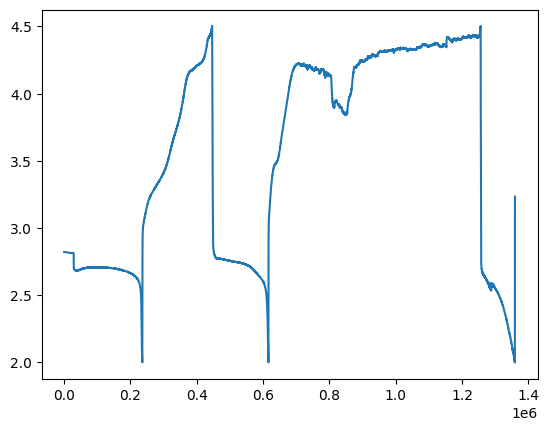

In [6]:
plt.plot(df['Test_Time(s)'], df['Voltage(V)'])

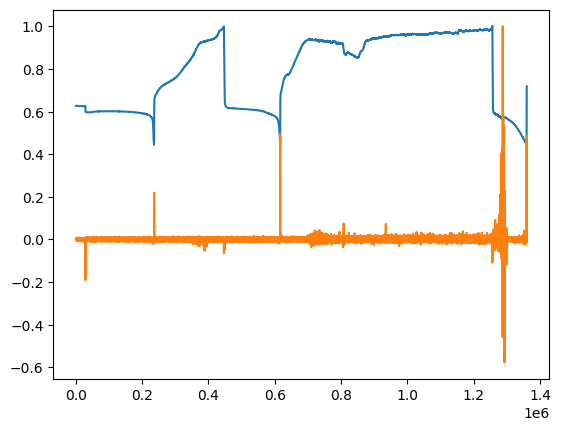

In [7]:
df['dV/dt(V/s)'].head()
plt.plot(df['Test_Time(s)'], df['Voltage(V)']/df['Voltage(V)'].max())
plt.plot(df['Test_Time(s)'], df['dV/dt(V/s)']/df['dV/dt(V/s)'].max())


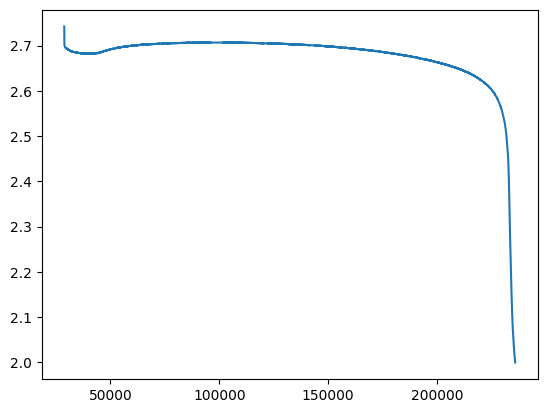

In [8]:
# point where normalised dV/dt exceeds 0.1 for the first time
first_cycle_index_end = np.where(df['dV/dt(V/s)']/df['dV/dt(V/s)'].max() > 0.2)[0][0]
first_cycle_index_start = np.where(df['dV/dt(V/s)']/df['dV/dt(V/s)'].max() < -0.1)[0][0]
#plot the first cycle
df_first_cycle = df[first_cycle_index_start:first_cycle_index_end]
plt.plot(df_first_cycle['Test_Time(s)'], df_first_cycle['Voltage(V)'])



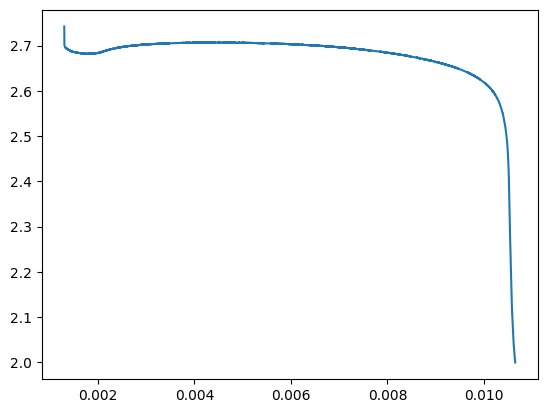

In [9]:

# plots voltage vs (Current * time / 3600) for first cycle
capacity_Ah = df_first_cycle['Test_Time(s)']*df_first_cycle['Current(A)']/-3600
plt.plot(capacity_Ah, df_first_cycle['Voltage(V)'] )



Text(0, 0.5, 'Voltage (V)')

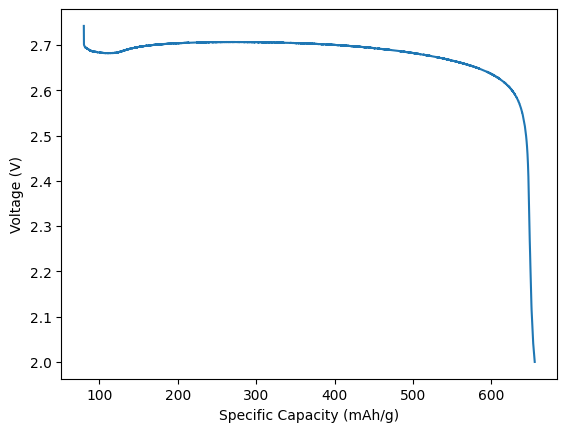

In [10]:
mass = 16.25 / 1000 #grams
specific_capacity_mAhg = capacity_Ah*1000/mass
plt.plot(specific_capacity_mAhg, df_first_cycle['Voltage(V)'] )
plt.xlabel('Specific Capacity (mAh/g)')
plt.ylabel('Voltage (V)')


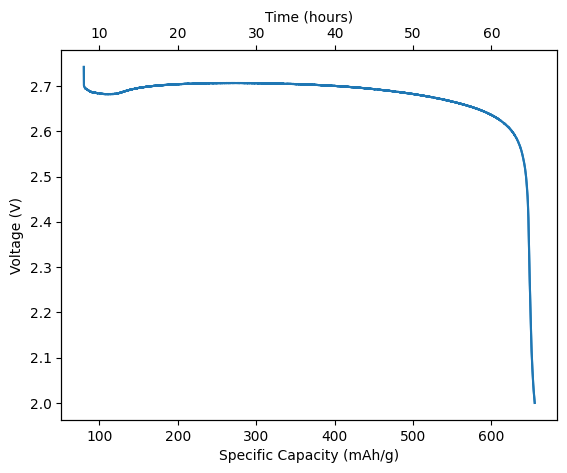

In [11]:
# plot voltage vs specific capacity on the bottom x axis and voltage vs time on the top x axis
fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax1.plot(specific_capacity_mAhg, df_first_cycle['Voltage(V)'] )
ax2.plot(df_first_cycle['Test_Time(s)']/3600, df_first_cycle['Voltage(V)'])
ax1.set_xlabel('Specific Capacity (mAh/g)')
ax1.set_ylabel('Voltage (V)')
ax2.set_xlabel('Time (hours)')
plt.show()


In [12]:
print(specific_capacity_mAhg)

481       80.023273
482       80.052080
483       80.079398
484       80.108609
485       80.136386
            ...    
21188    655.228422
21189    655.247751
21190    655.278817
21191    655.303307
21192    655.315139
Length: 20712, dtype: float64


C:\Users\lb958\AppData\Local\Temp\ipykernel_25976\3179125834.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


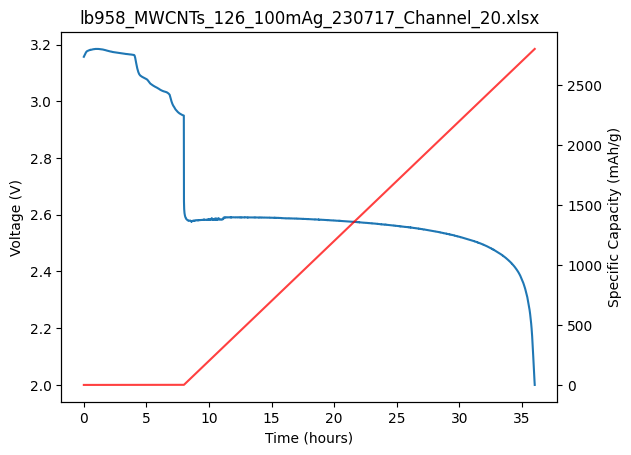

In [16]:
cell_100mAg_126_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_100mAg_230717\Channel_20\lb958_MWCNTs_126_100mAg_230717_Channel_20.xlsx"
cell_100mAg_126_mass = 1.26
plot_cell_data(cell_100mAg_126_path, cell_100mAg_126_mass,
                saveas = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_100mAg_230717\Channel_20\lb958_MWCNTs_126_100mAg_230717_Channel_20.png",
                show_discharge = True,)

C:\Users\lb958\AppData\Local\Temp\ipykernel_25976\3179125834.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


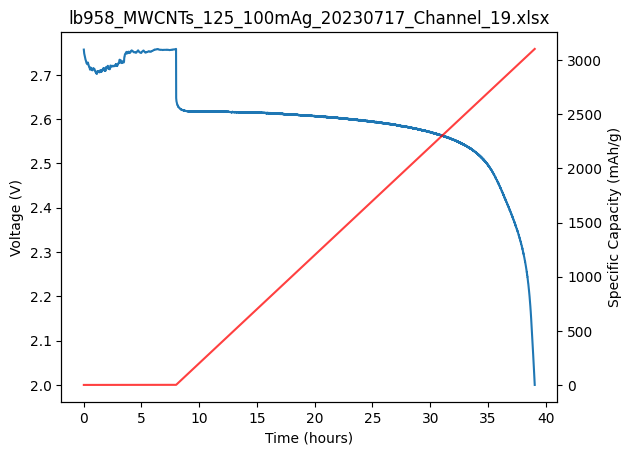

In [17]:
cell_100mAg_125_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_100mAg_20230717\Channel_19\lb958_MWCNTs_125_100mAg_20230717_Channel_19.xlsx"
cell_100mAg_125_mass = 1.25
plot_cell_data(cell_100mAg_125_path, cell_100mAg_125_mass, saveas = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_125_100mAg_20230717\Channel_19\lb958_MWCNTs_125_100mAg_20230717_Channel_19.png",
               show_discharge = True,)

C:\Users\lb958\AppData\Local\Temp\ipykernel_25976\3179125834.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


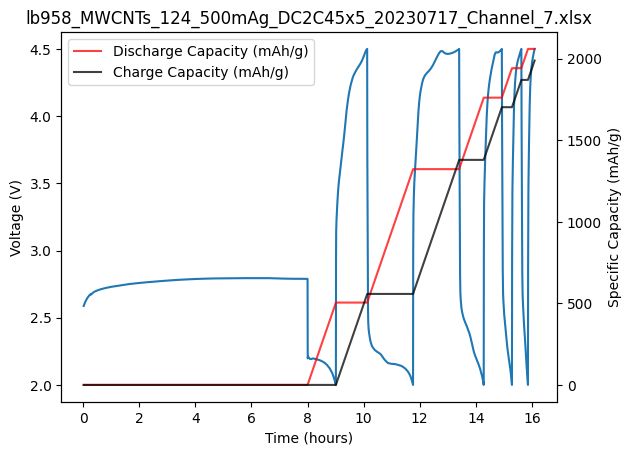

In [18]:
cell_500mAg_124_path = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717\Channel_7\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717_Channel_7.xlsx"
cell_500mAg_124_mass = 1.24
plot_cell_data(cell_500mAg_124_path, cell_500mAg_124_mass, saveas = r"c:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717\Channel_7\lb958_MWCNTs_124_500mAg_DC2C45x5_20230717_Channel_7.png",
               show_discharge=True, show_charge=True)

C:\Users\lb958\AppData\Local\Temp\ipykernel_25976\3179125834.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


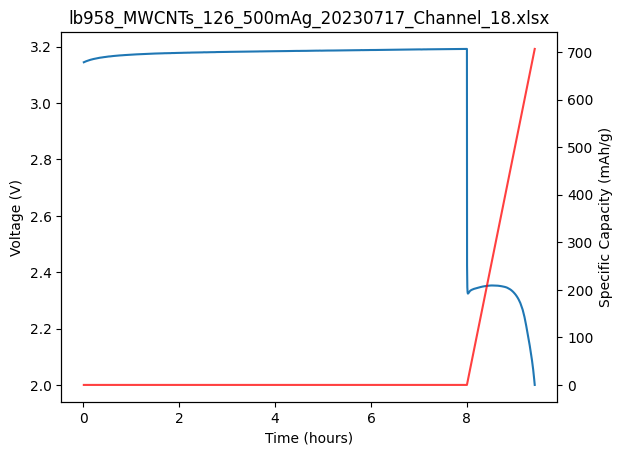

In [19]:
cell_500mAg_126_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_500mAg_20230717\Channel_18\lb958_MWCNTs_126_500mAg_20230717_Channel_18.xlsx"
cell_500mAg_126_mass = 1.26
plot_cell_data(cell_500mAg_126_path, cell_500mAg_126_mass, saveas = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_500mAg_20230717\Channel_18\lb958_MWCNTs_126_500mAg_20230717_Channel_18.png",
               show_discharge=True)

C:\Users\lb958\AppData\Local\Temp\ipykernel_25976\3179125834.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


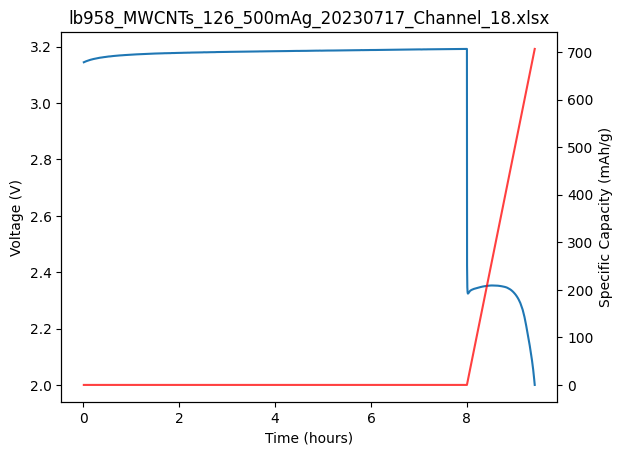

In [20]:
cell_500mAg_126_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_500mAg_20230717\Channel_18\lb958_MWCNTs_126_500mAg_20230717_Channel_18.xlsx"
cell_500mAg_126_mass = 1.26
plot_cell_data(cell_500mAg_126_path, cell_500mAg_126_mass, saveas = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNTs_126_500mAg_20230717\Channel_18\lb958_MWCNTs_126_500mAg_20230717_Channel_18.png",
               show_discharge=True)

C:\Users\lb958\AppData\Local\Temp\ipykernel_25976\3179125834.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


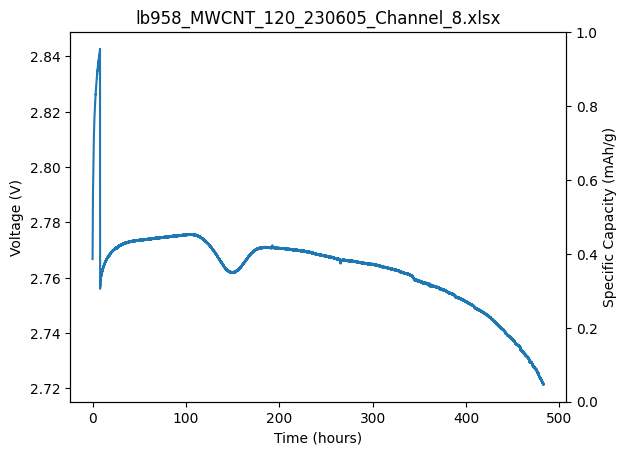

In [21]:
MWCNTs_120_path = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNT_120_230605\Channel_8\lb958_MWCNT_120_230605_Channel_8.xlsx"
MWCNTs_120_mass = 1.20
plot_cell_data(MWCNTs_120_path, MWCNTs_120_mass, saveas = r"C:\Users\lb958\OneDrive - University of Cambridge\Data\Midi\Cell\lb958_MWCNT_120_230605\Channel_8\lb958_MWCNT_120_230605_Channel_8.png")